# Fastai Classification - Device Model
This notebook features an example of training a classification model to determine the device model based on the photos of the chest X-ray images as well as device type information given as a column `Exaktes_Modell` in the metadata spreadsheet. As inputs, the model uses 256x256 crops of the original images containing the pacemaker/biomonitor device. Crops were generated using the segmentation pipeline.

In [1]:
import torch
import pandas as pd
from fastai.vision.all import *
import os
import numpy as np
import json
import sklearn
import pickle
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Setting the paths to the `Dataset` folder containing the images.
# Relative path is defined to keep the style consistent with that of the segmentation pipeline.
abs_dataset_path = Path("/workdir/cied/Dataset")
rel_dataset_path = Path(os.path.relpath(abs_dataset_path))

# Loading the metadata spreadsheet
df = pd.read_excel(abs_dataset_path / "04c_train_data_clf.xlsx")

# Providing relative paths to the filenames for the dataloader
df.loc[:, "patch_fname"] = df.loc[:, "patch_fname"].apply(lambda x: str(rel_dataset_path / "Classification" / x))

In [3]:
# Setting the experiment name to save the model
exp_name = "s256_cls_m"

In [4]:
# Initializing the dataloader
dls = ImageDataLoaders.from_df(
    df,
    fn_col="patch_fname",
    label_col="Exaktes_Modell",
    valid_col="is_valid",
    #     item_tfms=[*aug_transforms(size=512)], #This line had a bug in my setup, moved augmentations to batch_tfms
    item_tfms=Resize(256),  # new
    batch_tfms=[*aug_transforms(size=256, min_scale=0.1)],  # new
    bs=256,
)

In [5]:
# Setting the seeds for reproducibility purposes
set_seed(42, True)
dls.rng.seed(42)
# Initializing the learner
learner = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()

In [6]:
# Training the model
learner.fit_one_cycle(80)

epoch,train_loss,valid_loss,accuracy,time
0,4.403334,2.788082,0.248473,00:31
1,4.021397,2.437704,0.346911,00:25
2,3.539877,2.108118,0.433130,00:26
3,3.114359,1.734058,0.515275,00:25
4,2.713426,1.382184,0.606246,00:26
5,2.272673,1.143149,0.659878,00:25
6,2.099813,1.255624,0.618466,00:25
7,1.833386,1.054375,0.676171,00:25
8,1.619967,1.017834,0.693822,00:25
9,1.422326,0.876820,0.752885,00:26


The model achieves an overall accuracy of 0.85 on the validation dataset.

In [7]:
# Saving the model
save_model("models/{}".format(exp_name), learner.model, learner.opt)

## Visualizing results
In the text description for each image, true label is the one above, predicted label is below.

In [8]:
# Reading holdout dataframe
holdout_df = pd.read_excel(abs_dataset_path / "03c_holdout_data_clf.xlsx")

# Providing relative paths to the filenames for the dataloader
holdout_df.loc[:, "patch_fname"] = holdout_df.loc[:, "patch_fname"].apply(
    lambda x: str(rel_dataset_path / "Classification" / x)
)

In [9]:
# Replacing validation data with holdout (test) data in the dataloader
holdout_df = pd.concat([df[~df["is_valid"]], holdout_df])

In [10]:
# Initializing dataloader for testing
dls = ImageDataLoaders.from_df(
    holdout_df,
    fn_col="patch_fname",
    label_col="Exaktes_Modell",
    valid_col="is_valid",
    item_tfms=Resize(256),  # new
    batch_tfms=[*aug_transforms(size=256, min_scale=0.1)],  # new
    bs=16,
)

In [11]:
# Loading the model
learner = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
load_model("models/{}".format(exp_name), learner.model, learner.opt, device="cuda:0")

In [12]:
# Validating the model
res = learner.validate()
print(f"Validation accuracy: {res[1]:.3}")

Validation accuracy: 0.847


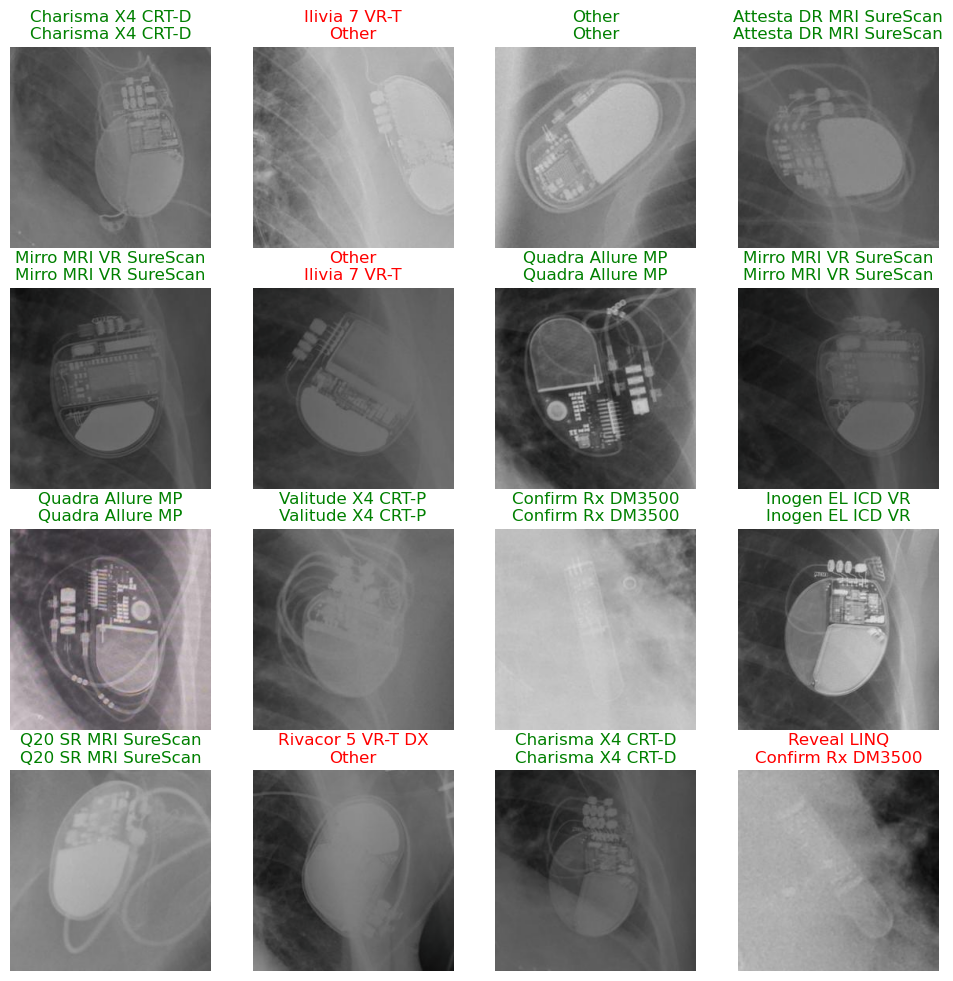

In [13]:
# Visualizing results: True label above, Prediction below
learner.show_results(max_n=16)

## Retrieving confidence intervals

In [14]:
res = learner.get_preds()

holdout_df = pd.read_excel(abs_dataset_path / "03_holdout_data_clf.xlsx")

probs = np.array(res[0])
targs = np.array(res[1])

preds = np.argmax(probs, axis=1)

output_df = pd.DataFrame(data=probs, columns=learner.dls[1].vocab)

output_df.columns = [str(i) + " - " + output_df.columns[i] for i in range(len(output_df.columns))]

output_df.loc[:, "Prediction"] = preds

output_df.loc[:, "Target"] = targs

output_df.index = holdout_df["patch_fname"]

output_df.to_excel(abs_dataset_path / "06c_preds_confidence_model.xlsx")